## Bias testing 
Choose one of the PREDICTANDS in the first cell and run entire cells to view the results.

In [1]:
# define the predictand
PREDICTAND = 'tasmean'  # 'tasmin' or 'tasmax' or 'tasmean'

In [2]:
# mapping from predictands to variable names
NAMES = {'tasmin': 'minimum temperature', 'tasmax': 'maximum temperature', 'tasmean': 'mean temperature'}
# dataset names mapping
PRED = 'EOBS $T_{\mathrm{mean \ daily}}$'
TRUE = 'Target $T_{\mathrm{mean \ daily}}$'

In [3]:
PRED

'EOBS $T_{\\mathrm{mean \\ daily}}$'

### Imports

In [4]:
# builtins
import datetime
import warnings
import calendar

# externals
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import scipy.stats as stats
from IPython.display import Image
from sklearn.metrics import r2_score

### Load datasets

In [5]:
if PREDICTAND == 'tasmin':
    y_pred = xr.open_dataset("/mnt/CEPH_PROJECTS/InterTwin/Climate_Downscaling/hydroModelDownscale/grid_search/tasmax/LGBMRegressor_tasmax_ztuvq_500_850_mslpt2_dem_sa_doy.nc")
    
if PREDICTAND == 'tasmax':
    y_pred = xr.open_dataset("/mnt/CEPH_PROJECTS/InterTwin/Climate_Downscaling/hydroModelDownscale/grid_search/tasmin/LGBMRegressor_tasmin_ztuvq_500_850_mslpt2_dem_sa_doy.nc")
    
if PREDICTAND == 'tasmean':
    y_pred = xr.open_dataset("/mnt/CEPH_PROJECTS/InterTwin/02_Original_Climate_Data/eobs/tasmean_eobs_1950_2023_reprojected.nc")    

y_pred
y_pred = y_pred.rename({'tg': PREDICTAND})

y_pred = y_pred.rename({'lon': "x"})
y_pred = y_pred.rename({'lat': "y"})


In [6]:
#y_pred = y_pred - 273.15

In [7]:
# CERRA Data
if PREDICTAND == 'tasmin':
    y_true = xr.open_dataset("/mnt/CEPH_PROJECTS/InterTwin/Climate_Downscaling/hydroModelDownscale/CERRA/tasmin/CERRA_tasmin_2m_temperature_1985_2020.nc")
    
if PREDICTAND == 'tasmax':
    y_true = xr.open_dataset("/mnt/CEPH_PROJECTS/InterTwin/Climate_Downscaling/hydroModelDownscale/CERRA/tasmax/CERRA_tasmax_2m_temperature_1985_2020.nc")
    
if PREDICTAND == 'tasmean':
    y_true = xr.open_dataset("/mnt/CEPH_PROJECTS/InterTwin/Climate_Downscaling/hydroModelDownscale/CERRA/tasmean/CERRA_2m_temperature_1985_2020.nc")    


y_true

y_true = y_true.rename({'lon': "x"})
y_true = y_true.rename({'lat': "y"})
y_true

<xarray.Dataset> Size: 813MB
Dimensions:            (x: 161, y: 96, time: 13149)
Coordinates:
  * x                  (x) float64 1kB 5.084 5.151 5.218 ... 15.69 15.76 15.82
  * y                  (y) float64 768B 43.62 43.69 43.75 ... 49.86 49.93 50.0
    heightAboveGround  float64 8B ...
  * time               (time) datetime64[ns] 105kB 1985-01-01 ... 2020-12-31
Data variables:
    t2m                (time, y, x) float32 813MB ...
Attributes:
    CDI:                     Climate Data Interface version 2.0.4 (https://mp...
    Conventions:             CF-1.7
    institution:             Norrkoping
    GRIB_centre:             eswi
    GRIB_centreDescription:  Norrkoping
    history:                 Fri Dec 08 06:52:58 2023: cdo remapbil,/mnt/CEPH...
    CDO:                     Climate Data Operators version 2.0.4 (https://mp...

In [8]:
y_true

<xarray.Dataset> Size: 813MB
Dimensions:            (x: 161, y: 96, time: 13149)
Coordinates:
  * x                  (x) float64 1kB 5.084 5.151 5.218 ... 15.69 15.76 15.82
  * y                  (y) float64 768B 43.62 43.69 43.75 ... 49.86 49.93 50.0
    heightAboveGround  float64 8B ...
  * time               (time) datetime64[ns] 105kB 1985-01-01 ... 2020-12-31
Data variables:
    t2m                (time, y, x) float32 813MB ...
Attributes:
    CDI:                     Climate Data Interface version 2.0.4 (https://mp...
    Conventions:             CF-1.7
    institution:             Norrkoping
    GRIB_centre:             eswi
    GRIB_centreDescription:  Norrkoping
    history:                 Fri Dec 08 06:52:58 2023: cdo remapbil,/mnt/CEPH...
    CDO:                     Climate Data Operators version 2.0.4 (https://mp...

In [9]:
# subset to time period covered by predictions
start_date = '2000-01-01'
end_date = '2020-12-31'
y_true = y_true.sel(time=slice(start_date, end_date))
y_pred = y_pred.sel(time=slice(start_date, end_date))
y_true = y_true.rename({'t2m': PREDICTAND})
y_true = y_true - 273.15

In [10]:
def get_time_range(dataset):
    time_coord = dataset.time

    # Get the starting and ending years
    start_year = time_coord.min().dt.year.item()
    end_year = time_coord.max().dt.year.item()

    return str(start_year), str(end_year)

start_year, end_year = get_time_range(y_pred)
print("Starting year:", start_year)
print("Ending year:", end_year)


Starting year: 2000
Ending year: 2020


In [11]:
# align datasets and mask missing values in Insitu:CERRA predictions
y_true, y_pred = xr.align(y_true[PREDICTAND], y_pred[PREDICTAND], join='override')

In [12]:
y_true

<xarray.DataArray 'tasmean' (time: 7671, y: 96, x: 161)> Size: 474MB
array([[[ 2.07089233e+00,  1.63259888e+00,  1.29473877e+00, ...,
          5.45034790e+00,  5.66220093e+00,  5.55755615e+00],
        [ 1.96691895e+00,  1.42034912e+00,  1.41397095e+00, ...,
          4.76577759e+00,  4.83248901e+00,  4.31259155e+00],
        [ 1.74063110e+00,  1.43209839e+00,  1.22650146e+00, ...,
          4.00482178e+00,  3.39898682e+00,  3.14910889e+00],
        ...,
        [ 2.38156128e+00,  2.35546875e+00,  2.24441528e+00, ...,
         -1.90267944e+00, -2.17306519e+00, -2.40820312e+00],
        [ 2.74212646e+00,  2.70965576e+00,  2.51208496e+00, ...,
         -1.57119751e+00, -1.71740723e+00, -1.68963623e+00],
        [ 3.29251099e+00,  3.29724121e+00,  2.98614502e+00, ...,
         -8.06304932e-01, -9.20837402e-01, -1.17837524e+00]],

       [[ 2.62487793e+00,  2.12194824e+00,  2.11471558e+00, ...,
          6.87322998e+00,  6.91357422e+00,  6.71459961e+00],
        [ 2.30368042e+00,  1.88168335e+00,  2.16235352e+00, ...,
          6.19793701e+00,  6.05416870e+00,  5.30538940e+00],
        [ 2.30139160e+00,  2.10275269e+00,  1.99386597e+00, ...,
          5.41171265e+00,  4.52359009e+00,  4.14202881e+00],
...
         -5.18798828e-02,  1.02996826e-01,  3.40057373e-01],
        [ 1.12130737e+00,  1.03991699e+00,  8.40179443e-01, ...,
          5.72174072e-01,  7.28149414e-01,  7.47528076e-01],
        [ 1.49710083e+00,  1.48391724e+00,  1.20376587e+00, ...,
          7.66448975e-01,  7.25341797e-01,  5.57159424e-01]],

       [[ 2.50469971e+00,  2.10748291e+00,  1.65328979e+00, ...,
          9.99710083e+00,  1.04682922e+01,  1.03207092e+01],
        [ 2.26345825e+00,  1.65612793e+00,  1.35229492e+00, ...,
          9.04882812e+00,  9.50592041e+00,  8.81369019e+00],
        [ 2.32278442e+00,  1.72387695e+00,  1.43087769e+00, ...,
          8.88253784e+00,  8.22308350e+00,  7.79711914e+00],
        ...,
        [ 2.62451172e-01,  2.16156006e-01,  1.00738525e-01, ...,
         -5.09857178e-01, -4.78790283e-01, -4.26788330e-01],
        [ 2.31750488e-01,  2.34710693e-01,  7.21435547e-02, ...,
         -7.19909668e-02, -1.60156250e-01, -2.47680664e-01],
        [ 3.79028320e-01,  4.74792480e-01,  2.86834717e-01, ...,
         -3.00659180e-01, -3.71185303e-01, -4.33563232e-01]]],
      dtype=float32)
Coordinates:
  * x                  (x) float64 1kB 5.084 5.151 5.218 ... 15.69 15.76 15.82
  * y                  (y) float64 768B 43.62 43.69 43.75 ... 49.86 49.93 50.0
    heightAboveGround  float64 8B ...
  * time               (time) datetime64[ns] 61kB 2000-01-01 ... 2020-12-31

In [13]:
y_pred

<xarray.DataArray 'tasmean' (time: 7671, y: 96, x: 161)> Size: 474MB
[118562976 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 61kB 2000-01-01 2000-01-02 ... 2020-12-31
  * x        (x) float64 1kB 5.084 5.151 5.218 5.285 ... 15.62 15.69 15.76 15.82
  * y        (y) float64 768B 43.62 43.69 43.75 43.82 ... 49.8 49.86 49.93 50.0
Attributes:
    standard_name:  air_temperature
    long_name:      mean temperature
    units:          Celsius
    cell_methods:   time: mean

In [14]:
### calculate monthly means
y_pred_mm = y_pred.groupby('time.month').mean(dim=('time'))
y_true_mm = y_true.groupby('time.month').mean(dim=('time'))

In [15]:
# calculate mean annual cycle
y_pred_ac = y_pred_mm.mean(dim=('x', 'y'))
y_true_ac = y_true_mm.mean(dim=('x', 'y'))

In [16]:
# compute daily anomalies
def anomalies(ds, timescale='time.dayofyear', standard=False):
        # group dataset by time scale
        groups = ds.groupby(timescale).groups

        # compute anomalies over time
        anomalies = {}
        for time, time_scale in groups.items():
            with warnings.catch_warnings():
                warnings.simplefilter('ignore', category=RuntimeWarning)
                # anomaly = (x(t) - mean(x, t))
                anomalies[time] = (ds.isel(time=time_scale) -
                                   ds.isel(time=time_scale).mean(dim='time'))

                # standardized anomaly = (x(t) - mean(x, t)) / std(x, t)
                if standard:
                    anomalies[time] /= ds.isel(time=time_scale).std(dim='time')

        # concatenate anomalies and sort chronologically
        anomalies = xr.concat(anomalies.values(), dim='time')
        anomalies = anomalies.sortby(anomalies.time)

        return anomalies

y_pred_anom = anomalies(y_pred, timescale='time.month')
y_true_anom = anomalies(y_true, timescale='time.month')

### Coefficient of determination

In [17]:
# get predicted and observed daily anomalies
y_pred_av = y_pred_anom.values.flatten()
y_true_av = y_true_anom.values.flatten()

# apply mask of valid pixels
mask = (~np.isnan(y_pred_av) & ~np.isnan(y_true_av))
y_pred_av = y_pred_av[mask]
y_true_av = y_true_av[mask]

# get predicted and observed monthly means
y_pred_mv = y_pred_mm.values.flatten()
y_true_mv = y_true_mm.values.flatten()

# apply mask of valid pixels
mask = (~np.isnan(y_pred_mv) & ~np.isnan(y_true_mv))
y_pred_mv = y_pred_mv[mask]
y_true_mv = y_true_mv[mask]

# calculate coefficient of determination on monthly means
r2_mm = r2_score(y_true_mv, y_pred_mv)
print('R2 on monthly means: {:.2f}'.format(r2_mm))

# calculate coefficient of determination on daily anomalies
r2_anom = r2_score(y_true_av, y_pred_av)
print('R2 on daily anomalies: {:.2f}'.format(r2_anom))

R2 on monthly means: 0.98
R2 on daily anomalies: 0.92


### Coefficient of determination: Spatially

In [18]:
# iterate over the grid points
r2 = np.ones((2, len(y_pred.x), len(y_pred.y)), dtype=np.float32) * np.nan
for i in range(len(y_pred.x)):
    for j in range(len(y_pred.y)):
        # get observed and predicted monthly mean temperature for current grid point
        point_true = y_true_mm.isel(x=i, y=j)
        point_pred = y_pred_mm.isel(x=i, y=j)

        # remove missing values
        mask = ((~np.isnan(point_true)) & (~np.isnan(point_pred)))
        point_true = point_true[mask].values
        point_pred = point_pred[mask].values
        if point_true.size < 1:
            continue
        
        # get anomalies for current grid point
        point_anom_true = y_true_anom.isel(x=i, y=j)
        point_anom_pred = y_pred_anom.isel(x=i, y=j)
        
        # remove missing values
        mask_anom = ((~np.isnan(point_anom_true)) & (~np.isnan(point_anom_pred)))
        point_anom_true = point_anom_true[mask_anom].values
        point_anom_pred = point_anom_pred[mask_anom].values

        # compute coefficient of determination
        r2[0, i, j] = r2_score(point_true, point_pred)
        r2[1, i, j] = r2_score(point_anom_true, point_anom_pred)

/tmp/ipykernel_249048/3372116010.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  grn = cm.get_cmap('Greens', 128)
/tmp/ipykernel_249048/3372116010.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  red = cm.get_cmap('Reds_r', 128)


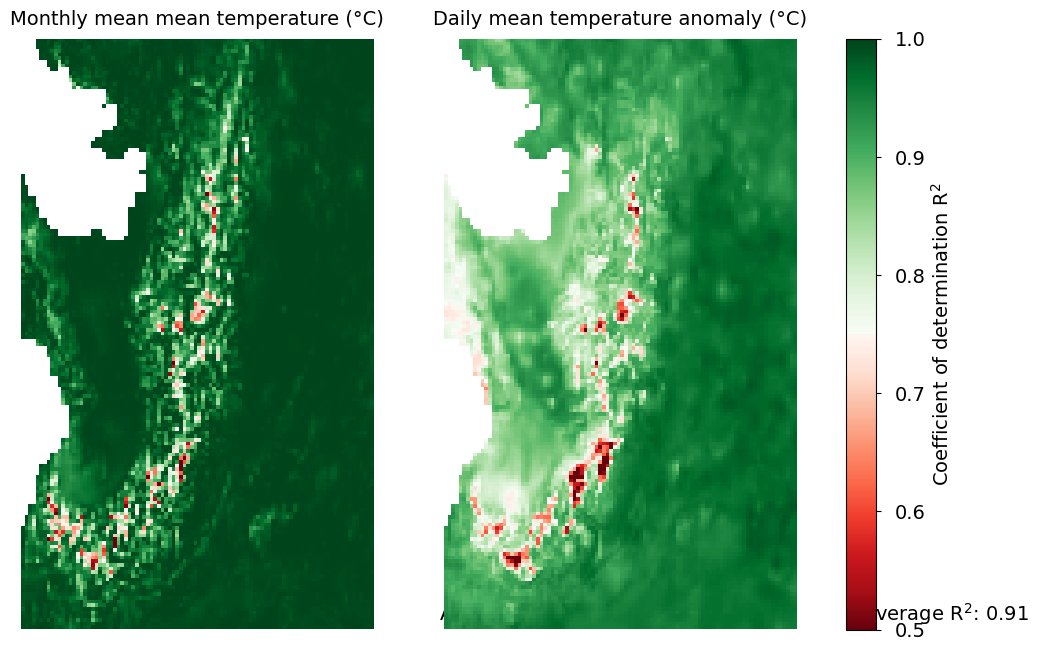

In [19]:
# define color map: red to green
grn = cm.get_cmap('Greens', 128)
red = cm.get_cmap('Reds_r', 128)
red2green = ListedColormap(np.vstack((red(np.linspace(0, 1, 128)),
                                      grn(np.linspace(0, 1, 128)))))

# plot coefficient of determination
vmin, vmax = 0.5, 1
fig, ax = plt.subplots(1, 2, figsize=(10, 10))

# monthly means
im0 = ax[0].imshow(r2[0, :], origin='lower', cmap=red2green, vmin=vmin, vmax=vmax)
ax[0].text(x=r2.shape[1] - 2, y=2, s='Average R$^2$: {:.2f}'.format(np.nanmean(r2[0, :])), fontsize=14, ha='right');
ax[0].set_axis_off()
ax[0].set_title('Monthly mean {} (°C)'.format(NAMES[PREDICTAND]), fontsize=14, pad=10);

# daily anomalies
im1 = ax[1].imshow(r2[1, :], origin='lower', cmap=red2green, vmin=vmin, vmax=vmax)
ax[1].text(x=r2.shape[1] - 2, y=2, s='Average R$^2$: {:.2f}'.format(np.nanmean(r2[1, :])), fontsize=14, ha='right');
ax[1].set_axis_off()
ax[1].set_title('Daily {} anomaly (°C)'.format(NAMES[PREDICTAND]), fontsize=14, pad=10);

# add colorbar 
cbar_ax_bias = fig.add_axes([ax[1].get_position().x1 + 0.05, ax[1].get_position().y0,
                             0.03, ax[1].get_position().y1 - ax[1].get_position().y0])
cbar_bias = fig.colorbar(im0, cax=cbar_ax_bias)
cbar_bias.set_label(label='Coefficient of determination R$^2$', fontsize=14)
cbar_bias.ax.tick_params(labelsize=14, pad=10)

# save figure
#fig.savefig('../Notebooks/Figures/{}_r2_spatial.png'.format(PREDICTAND), dpi=300, bbox_inches='tight')

### Bias

Calculate yearly average bias over entire reference period:

In [20]:
# yearly average bias over reference period
y_pred_yearly_avg = y_pred.groupby('time.year').mean(dim='time')
y_true_yearly_avg = y_true.groupby('time.year').mean(dim='time')
bias_yearly_avg = y_pred_yearly_avg - y_true_yearly_avg
print('({}:{}) Yearly average bias of {}: {:.2f}°C'.format(TRUE, PRED, PREDICTAND, bias_yearly_avg.mean().item()))

(Target $T_{\mathrm{mean \ daily}}$:EOBS $T_{\mathrm{mean \ daily}}$) Yearly average bias of tasmean: 0.47°C


In [21]:
# mean absolute error over reference period
mae_avg = np.abs(y_pred_yearly_avg - y_true_yearly_avg).mean()
print('({}:{}) Yearly average MAE of {}: {:.2f}°C'.format(TRUE, PRED, PREDICTAND, mae_avg.mean().item()))

(Target $T_{\mathrm{mean \ daily}}$:EOBS $T_{\mathrm{mean \ daily}}$) Yearly average MAE of tasmean: 0.69°C


In [22]:
# root mean squared error over reference period
rmse_avg = np.sqrt(((y_pred_yearly_avg - y_true_yearly_avg) ** 2).mean())
print('({}:{}) Yearly average RMSE of {}: {:.2f}°C'.format(TRUE, PRED, PREDICTAND, rmse_avg.mean().item()))

(Target $T_{\mathrm{mean \ daily}}$:EOBS $T_{\mathrm{mean \ daily}}$) Yearly average RMSE of tasmean: 1.01°C


Text(94, 12, 'RMSE = 1.01°C')

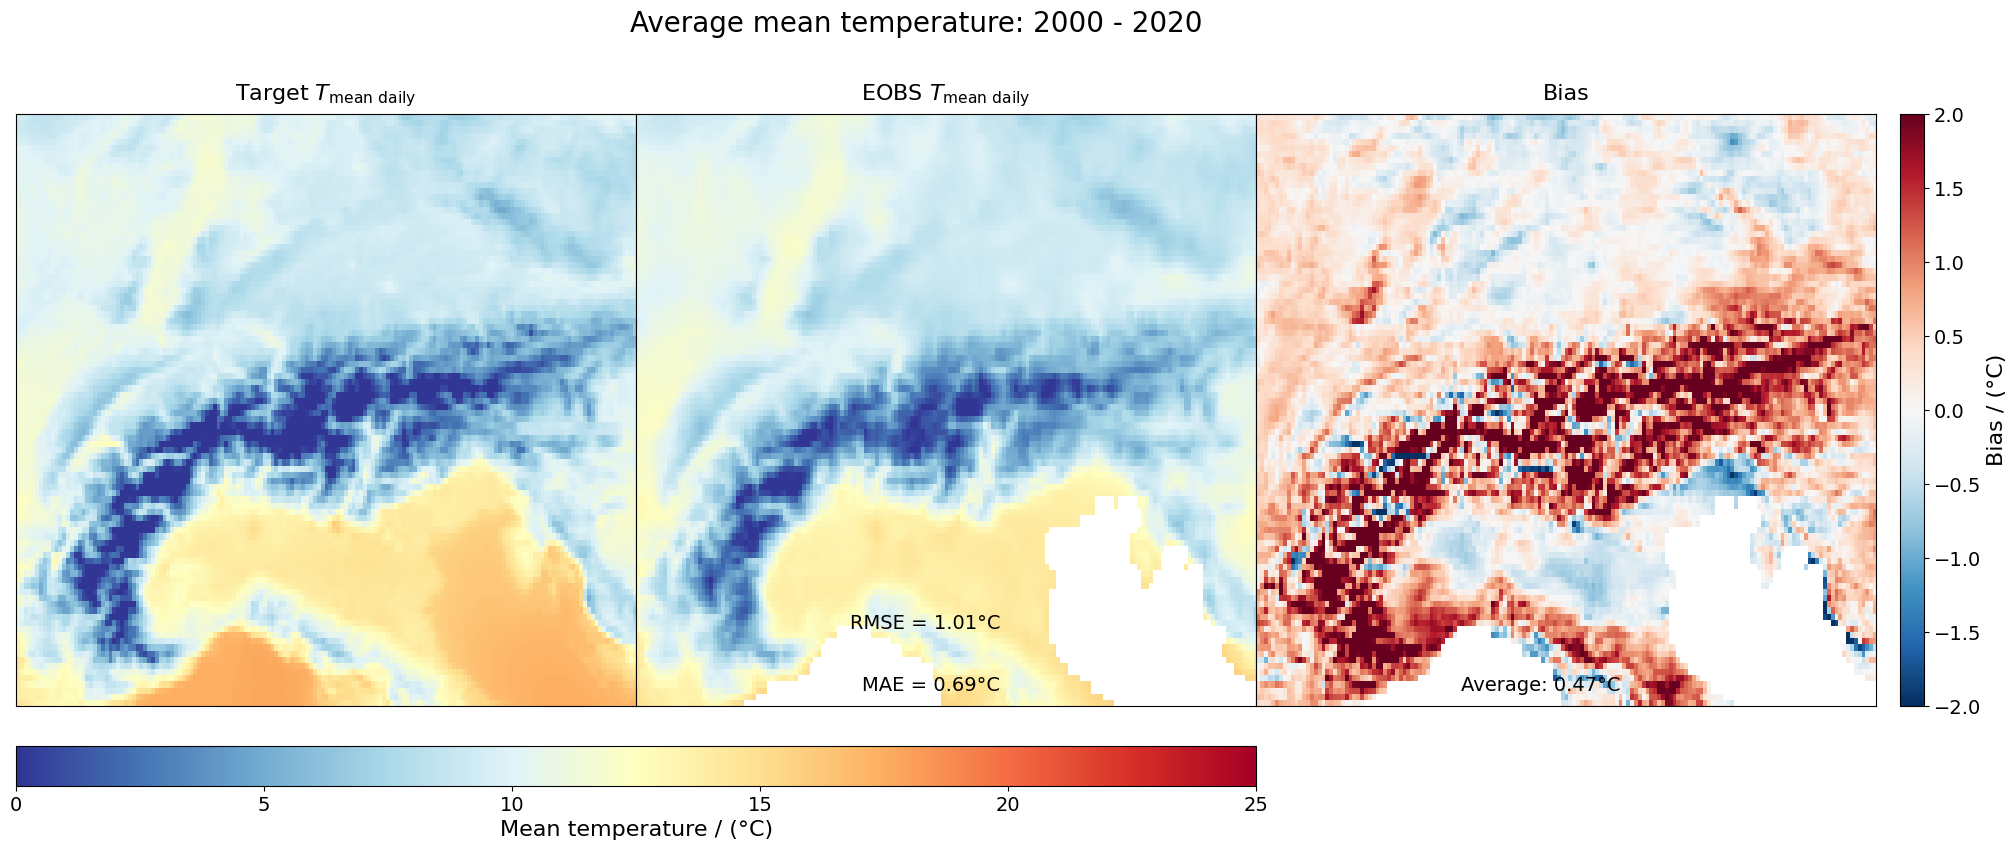

In [23]:
# plot average of observation, prediction, and bias
vmin, vmax = (-15, 15) if PREDICTAND == 'tasmin' else (0, 25)
fig, axes = plt.subplots(1, 3, figsize=(24, 8), sharex=True, sharey=True)
axes = axes.flatten()
for ds, ax in zip([y_true_yearly_avg, y_pred_yearly_avg, bias_yearly_avg], axes):
    if ds is bias_yearly_avg:
        ds = ds.mean(dim='year')
        im2 = ax.imshow(ds.values, origin='lower', cmap='RdBu_r', vmin=-2, vmax=2)
        ax.text(x=ds.shape[0] - 2, y=2, s='Average: {:.2f}°C'.format(ds.mean().item()), fontsize=14, ha='right')
    else:
        im1 = ax.imshow(ds.mean(dim='year').values, origin='upper', cmap='RdYlBu_r', vmin=vmin, vmax=vmax)
        
# set titles
axes[0].set_title(TRUE, fontsize=16, pad=10);
axes[1].set_title(PRED, fontsize=16, pad=10);
axes[2].set_title('Bias', fontsize=16, pad=10);

# adjust axes
for ax in axes.flat:
    ax.axes.get_xaxis().set_ticklabels([])
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticklabels([])
    ax.axes.get_yaxis().set_ticks([])
    ax.axes.axis('tight')
    ax.set_xlabel('')
    ax.set_ylabel('')

# adjust figure
fig.suptitle('Average {}: {} - {}'.format(NAMES[PREDICTAND], start_year, end_year), fontsize=20);
fig.subplots_adjust(hspace=0, wspace=0, top=0.85)

# add colorbar for bias
axes = axes.flatten()
cbar_ax_bias = fig.add_axes([axes[-1].get_position().x1 + 0.01, axes[-1].get_position().y0,
                             0.01, axes[-1].get_position().y1 - axes[-1].get_position().y0])
cbar_bias = fig.colorbar(im2, cax=cbar_ax_bias)
cbar_bias.set_label(label='Bias / (°C)', fontsize=16)
cbar_bias.ax.tick_params(labelsize=14)

# add colorbar for predictand
cbar_ax_predictand = fig.add_axes([axes[0].get_position().x0, axes[0].get_position().y0 - 0.1,
                                   axes[-1].get_position().x0 - axes[0].get_position().x0,
                                   0.05])
cbar_predictand = fig.colorbar(im1, cax=cbar_ax_predictand, orientation='horizontal')
cbar_predictand.set_label(label='{} / (°C)'.format(NAMES[PREDICTAND].capitalize()), fontsize=16)
cbar_predictand.ax.tick_params(labelsize=14)

# add metrics: MAE and RMSE
axes[1].text(x=ds.shape[0] - 2, y=2, s='MAE = {:.2f}°C'.format(mae_avg.mean().item()), fontsize=14, ha='right')
axes[1].text(x=ds.shape[0] - 2, y=12, s='RMSE = {:.2f}°C'.format(rmse_avg.mean().item()), fontsize=14, ha='right')

# save figure
#fig.savefig('../Notebooks/Figures/{}_average_bias.png'.format(PREDICTAND), dpi=300, bbox_inches='tight')

### Seasonal bias

Calculate seasonal bias:

In [24]:
# group data by season: (DJF, MAM, JJA, SON)
y_true_snl = y_true.groupby('time.season').mean(dim='time')
y_pred_snl = y_pred.groupby('time.season').mean(dim='time')
bias_snl = y_pred_snl - y_true_snl

In [25]:
# print average bias per season: Insitu:CERRA
for season in bias_snl.season:
    print('({}:{}) Average bias of mean {} for season {}: {:.1f}°C'.format(TRUE, PRED, PREDICTAND, season.item(), bias_snl.sel(season=season).mean().item()))

(Target $T_{\mathrm{mean \ daily}}$:EOBS $T_{\mathrm{mean \ daily}}$) Average bias of mean tasmean for season DJF: 0.6°C
(Target $T_{\mathrm{mean \ daily}}$:EOBS $T_{\mathrm{mean \ daily}}$) Average bias of mean tasmean for season JJA: 0.3°C
(Target $T_{\mathrm{mean \ daily}}$:EOBS $T_{\mathrm{mean \ daily}}$) Average bias of mean tasmean for season MAM: 0.5°C
(Target $T_{\mathrm{mean \ daily}}$:EOBS $T_{\mathrm{mean \ daily}}$) Average bias of mean tasmean for season SON: 0.5°C


Plot seasonal differences, taken from the [xarray documentation](xarray.pydata.org/en/stable/examples/monthly-means.html).

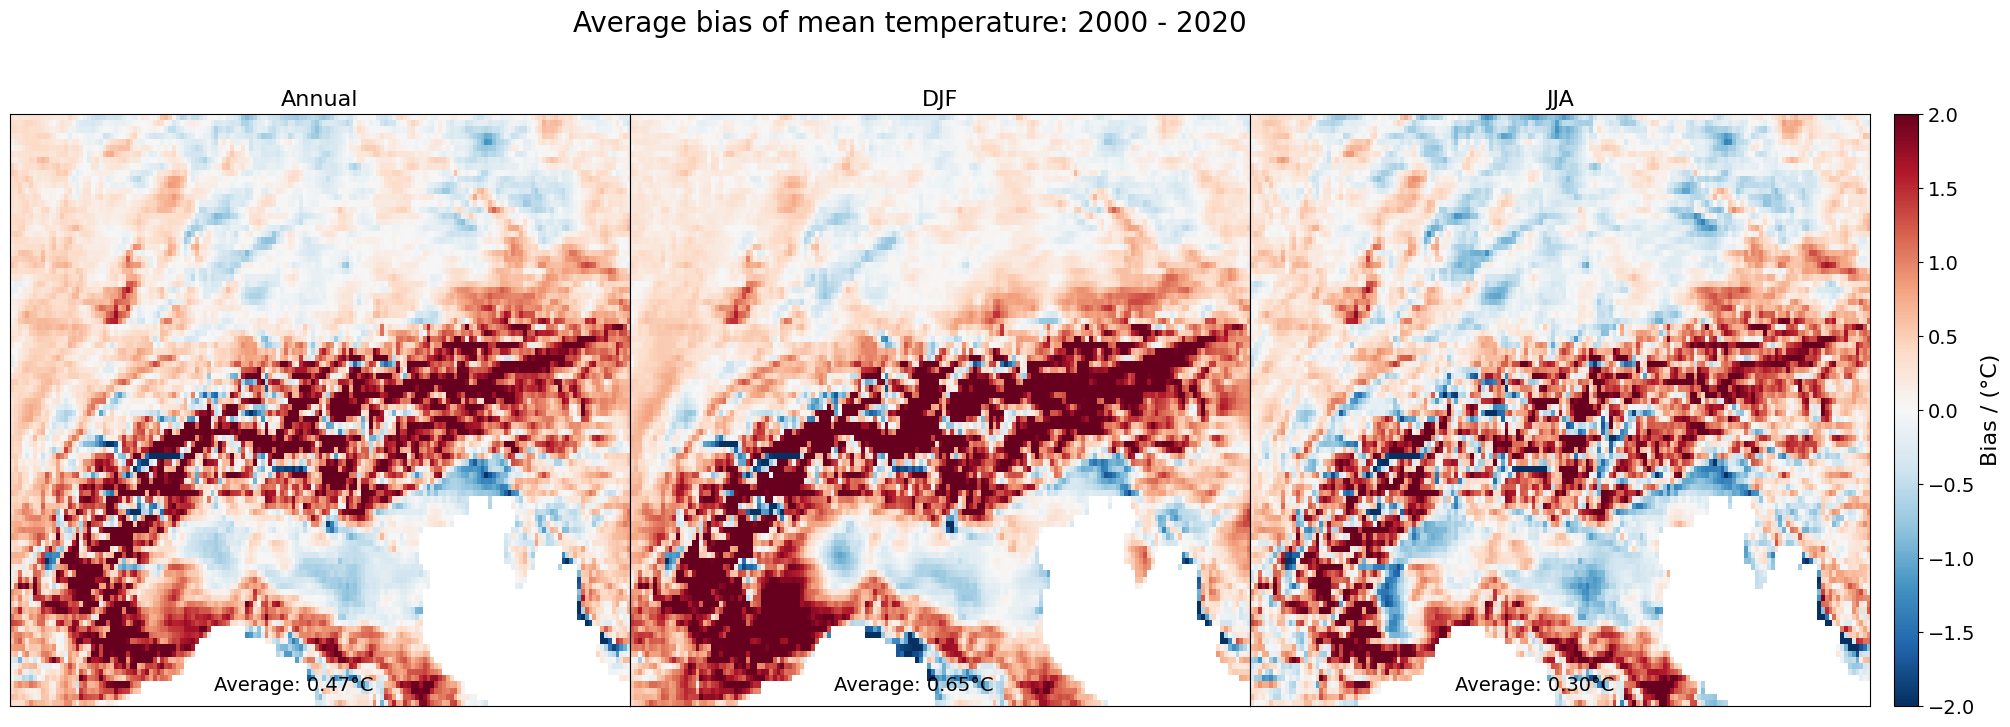

In [26]:
# plot seasonal differences
seasons = ('DJF', 'JJA')
fig, axes = plt.subplots(nrows=1, ncols=len(seasons) + 1, figsize=(24, 8), sharex=True, sharey=True)
axes = axes.flatten()

# plot annual average bias
ds = bias_yearly_avg.mean(dim='year')
im = axes[0].imshow(ds.values, origin='lower', cmap='RdBu_r', vmin=-2, vmax=2)
axes[0].set_title('Annual', fontsize=16);
axes[0].text(x=ds.shape[0] - 2, y=2, s='Average: {:.2f}°C'.format(ds.mean().item()), fontsize=14, ha='right')

# plot seasonal average bias
for ax, season in zip(axes[1:], seasons):
    ds = bias_snl.sel(season=season)
    ax.imshow(ds.values, origin='lower', cmap='RdBu_r', vmin=-2, vmax=2)
    ax.set_title(season, fontsize=16);
    ax.text(x=ds.shape[0] - 2, y=2, s='Average: {:.2f}°C'.format(ds.mean().item()), fontsize=14, ha='right')

# adjust axes
for ax in axes.flat:
    ax.axes.get_xaxis().set_ticklabels([])
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticklabels([])
    ax.axes.get_yaxis().set_ticks([])
    ax.axes.axis('tight')
    ax.set_xlabel('')
    ax.set_ylabel('')

# adjust figure
fig.suptitle('Average bias of {}: {} - {}'.format(NAMES[PREDICTAND], start_year, end_year), fontsize=20);
fig.subplots_adjust(hspace=0, wspace=0, top=0.85)

# add colorbar
cbar_ax_predictand = fig.add_axes([axes[-1].get_position().x1 + 0.01, axes[-1].get_position().y0,
                                   0.01, axes[0].get_position().y1 - axes[-1].get_position().y0])
cbar_predictand = fig.colorbar(im, cax=cbar_ax_predictand)
cbar_predictand.set_label(label='Bias / (°C)', fontsize=16)
cbar_predictand.ax.tick_params(labelsize=14)

# save figure
#fig.savefig('../Notebooks/Figures/{}_bias_seasonal.png'.format(PREDICTAND), dpi=300, bbox_inches='tight')

### Bias of extreme values

In [27]:
# extreme quantile of interest
quantile = 0.02 if PREDICTAND == 'tasmin' else 0.98

In [28]:
# calculate extreme quantile for each year
with warnings.catch_warnings():
    warnings.simplefilter('ignore', category=RuntimeWarning)
    y_pred_ex = y_pred.groupby('time.year').quantile(quantile, dim='time')
    y_true_ex = y_true.groupby('time.year').quantile(quantile, dim='time')

In [29]:
# calculate bias in extreme quantile for each year
bias_ex = y_pred_ex - y_true_ex

In [30]:
# bias of extreme quantile: Insitu:CERRA
print('({}:{}) Yearly average bias for P{:.0f} of {}: {:.1f}°C'.format(TRUE, PRED, quantile * 100, PREDICTAND, bias_ex.mean().item()))

(Target $T_{\mathrm{mean \ daily}}$:EOBS $T_{\mathrm{mean \ daily}}$) Yearly average bias for P98 of tasmean: 0.2°C


In [31]:
# mean absolute error in extreme quantile
mae_ex = np.abs(y_pred_ex - y_true_ex).mean()

In [32]:
# mae of extreme quantile: Insitu:CERRA
print('({}:{}) Yearly average MAE for P{:.0f} of {}: {:.1f}°C'.format(TRUE, PRED, quantile * 100, PREDICTAND, mae_ex.item()))

(Target $T_{\mathrm{mean \ daily}}$:EOBS $T_{\mathrm{mean \ daily}}$) Yearly average MAE for P98 of tasmean: 0.9°C


In [33]:
# root mean squared error in extreme quantile
rmse_ex = np.sqrt(((y_pred_ex - y_true_ex) ** 2).mean())

In [34]:
# rmse of extreme quantile: Insitu:CERRA
print('({}:{}) Yearly average RMSE for P{:.0f} of {}: {:.1f}°C'.format(TRUE, PRED, quantile * 100, PREDICTAND, rmse_ex.item()))

(Target $T_{\mathrm{mean \ daily}}$:EOBS $T_{\mathrm{mean \ daily}}$) Yearly average RMSE for P98 of tasmean: 1.3°C


Text(94, 12, 'RMSE = 1.26°C$^2$')

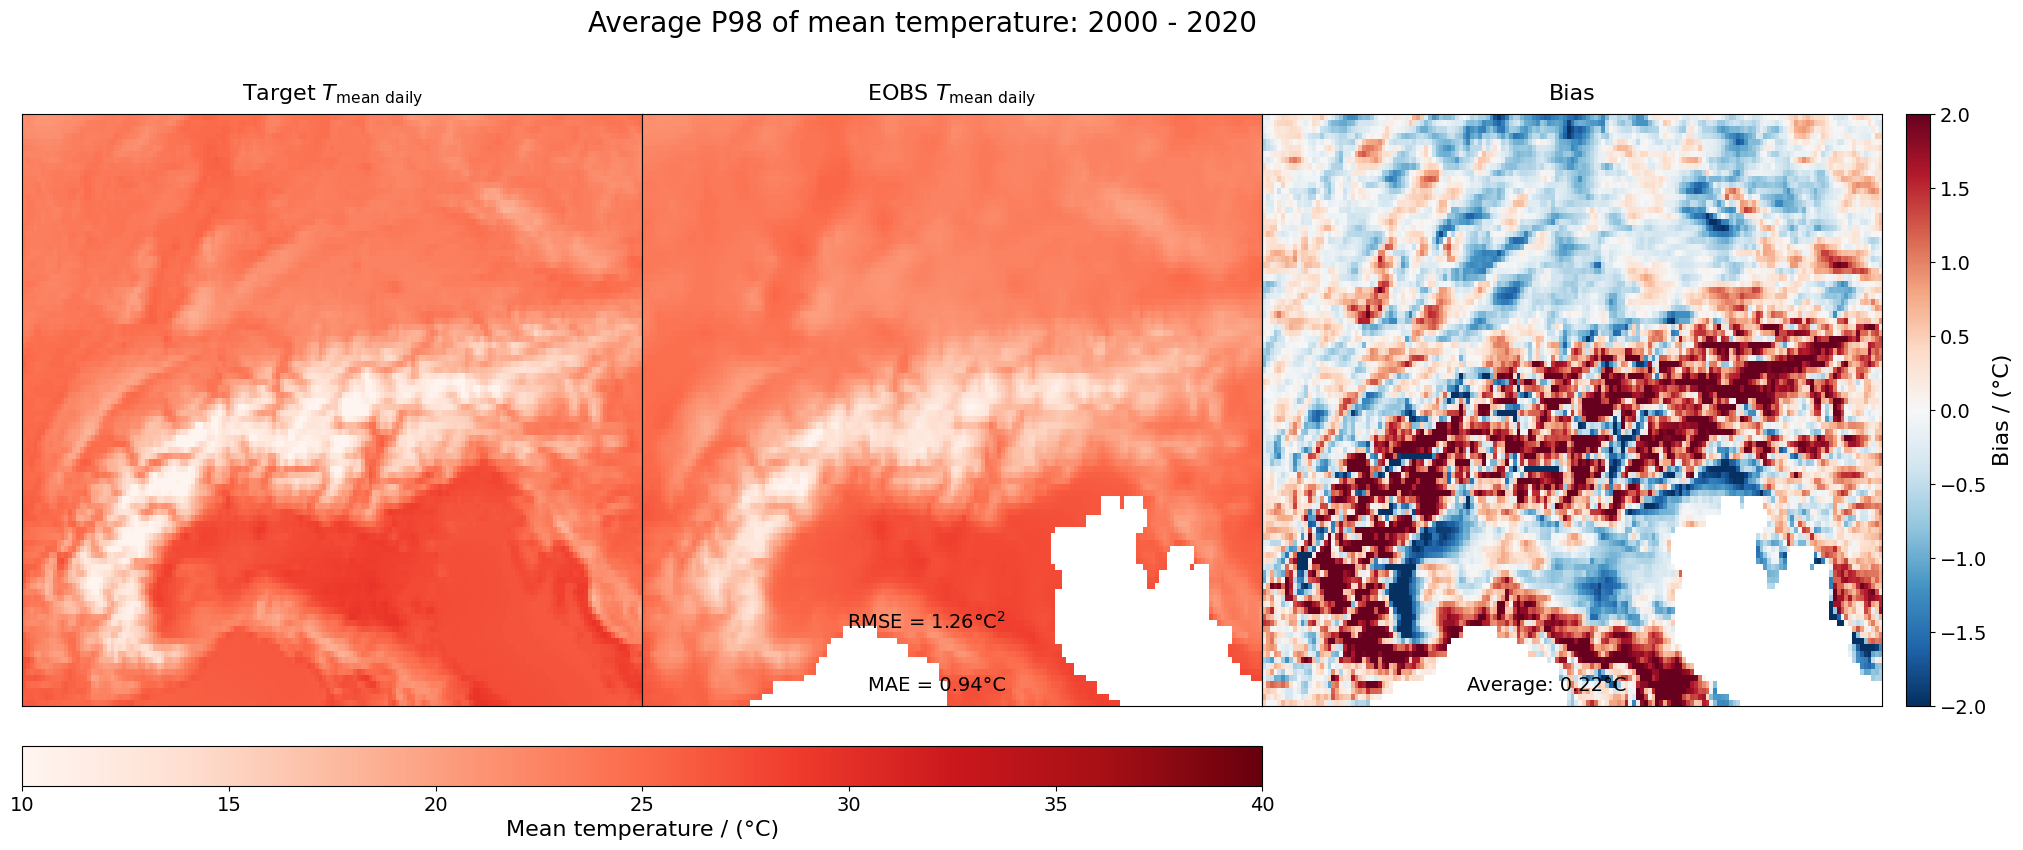

In [35]:
# plot extremes of observation, prediction, and bias
vmin, vmax = (-20, 0) if PREDICTAND == 'tasmin' else (10, 40)
fig, axes = plt.subplots(1, 3, figsize=(24, 8), sharex=True, sharey=True)
axes = axes.flatten()
for ds, ax in zip([y_true_ex, y_pred_ex, bias_ex], axes):
    if ds is bias_ex:
        ds = ds.mean(dim='year')
        im2 = ax.imshow(ds.values, origin='lower', cmap='RdBu_r', vmin=-2, vmax=2)
        ax.text(x=ds.shape[0] - 2, y=2, s='Average: {:.2f}°C'.format(ds.mean().item()), fontsize=14, ha='right')
    else:
        im1 = ax.imshow(ds.mean(dim='year').values, origin='upper', cmap='Blues_r' if PREDICTAND == 'tasmin' else 'Reds',
                        vmin=vmin, vmax=vmax)

# set titles
axes[0].set_title(TRUE, fontsize=16, pad=10);
axes[1].set_title(PRED, fontsize=16, pad=10);
axes[2].set_title('Bias', fontsize=16, pad=10);

# adjust axes
for ax in axes.flat:
    ax.axes.get_xaxis().set_ticklabels([])
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticklabels([])
    ax.axes.get_yaxis().set_ticks([])
    ax.axes.axis('tight')
    ax.set_xlabel('')
    ax.set_ylabel('')

# adjust figure
fig.suptitle('Average P{:.0f} of {}: {} - {}'.format(quantile * 100, NAMES[PREDICTAND], start_year, end_year), fontsize=20);
fig.subplots_adjust(hspace=0, wspace=0, top=0.85)

# add colorbar for bias
axes = axes.flatten()
cbar_ax = fig.add_axes([axes[-1].get_position().x1 + 0.01, axes[-1].get_position().y0,
                        0.01, axes[-1].get_position().y1 - axes[-1].get_position().y0])
cbar = fig.colorbar(im2, cax=cbar_ax)
cbar.set_label(label='Bias / (°C)', fontsize=16)
cbar.ax.tick_params(labelsize=14)

# add colorbar for predictand
cbar_ax_predictand = fig.add_axes([axes[0].get_position().x0, axes[0].get_position().y0 - 0.1,
                                   axes[-1].get_position().x0 - axes[0].get_position().x0,
                                   0.05])
cbar_predictand = fig.colorbar(im1, cax=cbar_ax_predictand, orientation='horizontal')
cbar_predictand.set_label(label='{} / (°C)'.format(NAMES[PREDICTAND].capitalize()), fontsize=16)
cbar_predictand.ax.tick_params(labelsize=14)

# add metrics: MAE and RMSE
axes[1].text(x=ds.shape[0] - 2, y=2, s='MAE = {:.2f}°C'.format(mae_ex.item()), fontsize=14, ha='right')
axes[1].text(x=ds.shape[0] - 2, y=12, s='RMSE = {:.2f}°C$^2$'.format(rmse_ex.item()), fontsize=14, ha='right')

# save figure
#fig.savefig('../Notebooks/Figures/{}_bias_p{:.0f}.png'.format(PREDICTAND, quantile * 100), dpi=300, bbox_inches='tight')

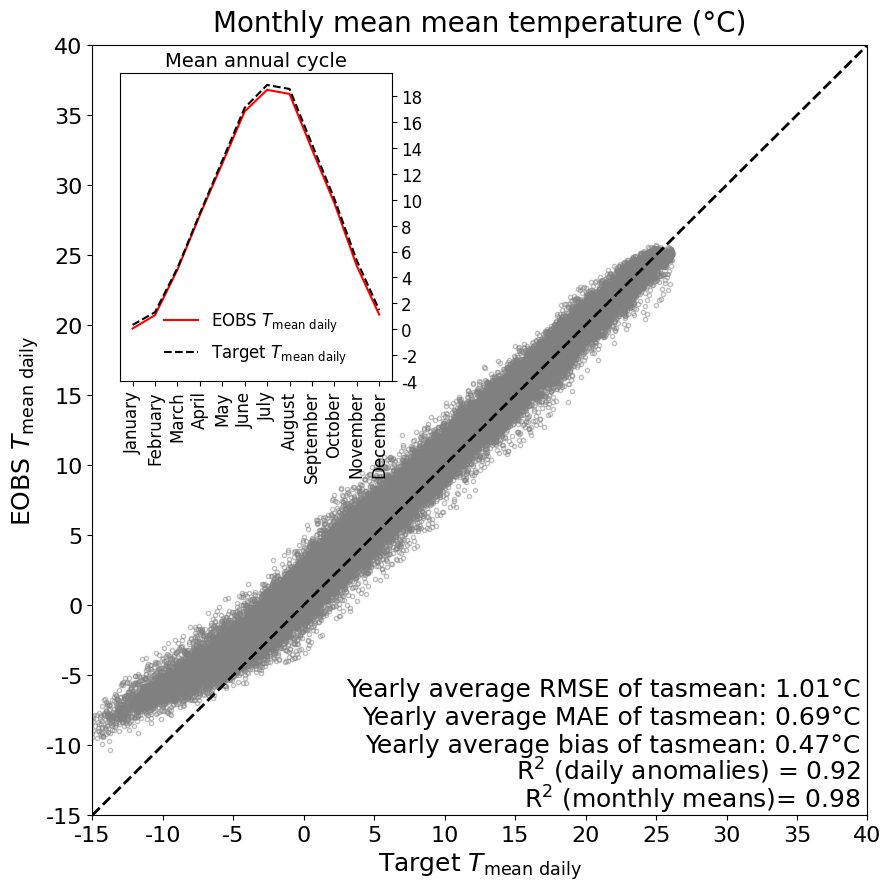

In [36]:
# scatter plot of observations vs. predictions
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# plot entire dataset
ax.plot(y_true_mv, y_pred_mv, 'o', alpha=.5, markeredgecolor='grey', markerfacecolor='none', markersize=3)

# plot 1:1 mapping line
if PREDICTAND == 'tasmin':
    interval = np.arange(-25, 30, 5)
else:
    interval = np.arange(-15, 45, 5)

ax.plot(interval, interval, color='k', lw=2, ls='--')

# add coefficients of determination
ax.text(interval[-1] - 0.5, interval[0] + 0.5, s='R$^2$ (monthly means)= {:.2f}'.format(r2_mm), ha='right', fontsize=18)
ax.text(interval[-1] - 0.5, interval[0] + 2.5, s='R$^2$ (daily anomalies) = {:.2f}'.format(r2_anom), ha='right', fontsize=18)
ax.text(interval[-1] - 0.5, interval[0] + 4.5, s='Yearly average bias of {}: {:.2f}°C'.format(PREDICTAND, bias_yearly_avg.mean().item()), ha='right', fontsize=18)
ax.text(interval[-1] - 0.5, interval[0] + 6.5, s='Yearly average MAE of {}: {:.2f}°C'.format(PREDICTAND, mae_avg.mean().item()), ha='right', fontsize=18)
ax.text(interval[-1] - 0.5, interval[0] + 8.5, s='Yearly average RMSE of {}: {:.2f}°C'.format(PREDICTAND, rmse_avg.mean().item()), ha='right', fontsize=18)


# format axes
ax.set_ylim(interval[0], interval[-1])
ax.set_xlim(interval[0], interval[-1])
ax.set_xticks(interval)
ax.set_xticklabels(interval, fontsize=16)
ax.set_yticks(interval)
ax.set_yticklabels(interval, fontsize=16)
ax.set_xlabel('Target $T_{\mathrm{mean \ daily}}$', fontsize=18)
ax.set_ylabel(PRED, fontsize=18)
ax.set_title('Monthly mean {} (°C)'.format(NAMES[PREDICTAND]), fontsize=20, pad=10);

# add axis for annual cycle
axins = inset_axes(ax, width="35%", height="40%", loc=2, borderpad=2)
axins.plot(y_pred_ac.values, ls='-', color='r', label=PRED)
axins.plot(y_true_ac.values, ls='--', color='k', label='Target $T_{\mathrm{mean \ daily}}$')
axins.legend(frameon=False, fontsize=12, loc='lower center');
axins.yaxis.tick_right()
axins.set_yticks(np.arange(-10, 11, 2) if PREDICTAND == 'tasmin' else np.arange(-4, 20, 2))
axins.set_yticklabels(np.arange(-10, 11, 2) if PREDICTAND == 'tasmin' else np.arange(-4, 20, 2), fontsize=12)
axins.set_xticks(np.arange(0, 12))
axins.set_xticklabels([calendar.month_name[i + 1] for i in np.arange(0, 12)], rotation=90, fontsize=12)
axins.set_title('Mean annual cycle', fontsize=14, pad=5);

plt.savefig('mslp.png', dpi=300, bbox_inches='tight')


In [37]:
import xarray as xr

era5 = xr.open_dataset("/mnt/CEPH_PROJECTS/InterTwin/Climate_Downscaling/hydroModelDownscale/REANALYSIS/ERA5_renamed/2m_temperature/ERA5_2m_temperature_1981_2020.nc")

In [38]:
era5

<xarray.Dataset> Size: 903MB
Dimensions:  (time: 14610, x: 161, y: 96)
Coordinates:
  * time     (time) datetime64[ns] 117kB 1981-01-01 1981-01-02 ... 2020-12-31
  * x        (x) float64 1kB 5.084 5.151 5.218 5.285 ... 15.62 15.69 15.76 15.82
  * y        (y) float64 768B 43.62 43.69 43.75 43.82 ... 49.8 49.86 49.93 50.0
Data variables:
    t2m      (time, y, x) float32 903MB ...
Attributes:
    CDI:          Climate Data Interface version 2.0.4 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Fri Dec 08 14:07:51 2023: cdo -O -s -remapbil,/mnt/CEPH_PRO...
    CDO:          Climate Data Operators version 2.0.4 (https://mpimet.mpg.de...

In [39]:
era5 = era5.sel(time=y_pred.time)


In [40]:
era5 = era5.rename({"t2m":PREDICTAND})

In [41]:
era5 = era5 - 273.15

In [42]:
era5

<xarray.Dataset> Size: 474MB
Dimensions:  (time: 7671, x: 161, y: 96)
Coordinates:
  * time     (time) datetime64[ns] 61kB 2000-01-01 2000-01-02 ... 2020-12-31
  * x        (x) float64 1kB 5.084 5.151 5.218 5.285 ... 15.62 15.69 15.76 15.82
  * y        (y) float64 768B 43.62 43.69 43.75 43.82 ... 49.8 49.86 49.93 50.0
Data variables:
    tasmean  (time, y, x) float32 474MB 2.62 2.242 1.863 ... 0.09027 0.003448
Attributes:
    CDI:          Climate Data Interface version 2.0.4 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Fri Dec 08 14:07:51 2023: cdo -O -s -remapbil,/mnt/CEPH_PRO...
    CDO:          Climate Data Operators version 2.0.4 (https://mpimet.mpg.de...

In [43]:
y_true

<xarray.DataArray 'tasmean' (time: 7671, y: 96, x: 161)> Size: 474MB
array([[[ 2.07089233e+00,  1.63259888e+00,  1.29473877e+00, ...,
          5.45034790e+00,  5.66220093e+00,  5.55755615e+00],
        [ 1.96691895e+00,  1.42034912e+00,  1.41397095e+00, ...,
          4.76577759e+00,  4.83248901e+00,  4.31259155e+00],
        [ 1.74063110e+00,  1.43209839e+00,  1.22650146e+00, ...,
          4.00482178e+00,  3.39898682e+00,  3.14910889e+00],
        ...,
        [ 2.38156128e+00,  2.35546875e+00,  2.24441528e+00, ...,
         -1.90267944e+00, -2.17306519e+00, -2.40820312e+00],
        [ 2.74212646e+00,  2.70965576e+00,  2.51208496e+00, ...,
         -1.57119751e+00, -1.71740723e+00, -1.68963623e+00],
        [ 3.29251099e+00,  3.29724121e+00,  2.98614502e+00, ...,
         -8.06304932e-01, -9.20837402e-01, -1.17837524e+00]],

       [[ 2.62487793e+00,  2.12194824e+00,  2.11471558e+00, ...,
          6.87322998e+00,  6.91357422e+00,  6.71459961e+00],
        [ 2.30368042e+00,  1.88168335e+00,  2.16235352e+00, ...,
          6.19793701e+00,  6.05416870e+00,  5.30538940e+00],
        [ 2.30139160e+00,  2.10275269e+00,  1.99386597e+00, ...,
          5.41171265e+00,  4.52359009e+00,  4.14202881e+00],
...
         -5.18798828e-02,  1.02996826e-01,  3.40057373e-01],
        [ 1.12130737e+00,  1.03991699e+00,  8.40179443e-01, ...,
          5.72174072e-01,  7.28149414e-01,  7.47528076e-01],
        [ 1.49710083e+00,  1.48391724e+00,  1.20376587e+00, ...,
          7.66448975e-01,  7.25341797e-01,  5.57159424e-01]],

       [[ 2.50469971e+00,  2.10748291e+00,  1.65328979e+00, ...,
          9.99710083e+00,  1.04682922e+01,  1.03207092e+01],
        [ 2.26345825e+00,  1.65612793e+00,  1.35229492e+00, ...,
          9.04882812e+00,  9.50592041e+00,  8.81369019e+00],
        [ 2.32278442e+00,  1.72387695e+00,  1.43087769e+00, ...,
          8.88253784e+00,  8.22308350e+00,  7.79711914e+00],
        ...,
        [ 2.62451172e-01,  2.16156006e-01,  1.00738525e-01, ...,
         -5.09857178e-01, -4.78790283e-01, -4.26788330e-01],
        [ 2.31750488e-01,  2.34710693e-01,  7.21435547e-02, ...,
         -7.19909668e-02, -1.60156250e-01, -2.47680664e-01],
        [ 3.79028320e-01,  4.74792480e-01,  2.86834717e-01, ...,
         -3.00659180e-01, -3.71185303e-01, -4.33563232e-01]]],
      dtype=float32)
Coordinates:
  * x                  (x) float64 1kB 5.084 5.151 5.218 ... 15.69 15.76 15.82
  * y                  (y) float64 768B 43.62 43.69 43.75 ... 49.86 49.93 50.0
    heightAboveGround  float64 8B ...
  * time               (time) datetime64[ns] 61kB 2000-01-01 ... 2020-12-31

In [44]:
import numpy

data = era5.mean(dim=["y", "x"])
#SEAS5 Forecast Data Spatial Aggregation
#data = y_pred.mean(['y', 'x'])

#data = data[list(data.data_vars)[0]]
#data
variable = list(data.data_vars)[0]
data = data.groupby('time.year').mean(keep_attrs=True)
data = data.tasmean  


#CERRA Reanalysis Data Spatial Aggregation
ref = y_true.mean(['y', 'x'])
#ref = ref[list(ref.data_vars)[0]]
ref = ref.groupby('time.year').mean(keep_attrs=True)
ref = ref.drop_vars("heightAboveGround")

obs = y_pred.mean(['y', 'x'])
#obs = obs[list(obs.data_vars)[0]]
obs = obs.groupby('time.year').mean(keep_attrs=True)



In [45]:
ref

<xarray.DataArray 'tasmean' (year: 21)> Size: 84B
array([ 9.620759 ,  9.070597 ,  9.534106 ,  9.630719 ,  8.844022 ,
        8.592509 ,  9.382315 ,  9.754264 ,  9.400234 ,  9.469521 ,
        8.400403 ,  9.795283 ,  9.381959 ,  9.049681 , 10.276238 ,
       10.158029 ,  9.657762 ,  9.7238245, 10.447194 , 10.1290865,
       10.229804 ], dtype=float32)
Coordinates:
  * year     (year) int64 168B 2000 2001 2002 2003 2004 ... 2017 2018 2019 2020

In [46]:
obs

<xarray.DataArray 'tasmean' (year: 21)> Size: 84B
array([ 9.440318 ,  8.837274 ,  9.34165  ,  9.415185 ,  8.612111 ,
        8.363621 ,  9.117965 ,  9.44501  ,  9.056573 ,  9.0856495,
        7.957344 ,  9.593968 ,  9.129845 ,  8.668385 ,  9.912884 ,
        9.887817 ,  9.307472 ,  9.385864 , 10.076005 ,  9.858339 ,
        9.892055 ], dtype=float32)
Coordinates:
  * year     (year) int64 168B 2000 2001 2002 2003 2004 ... 2017 2018 2019 2020

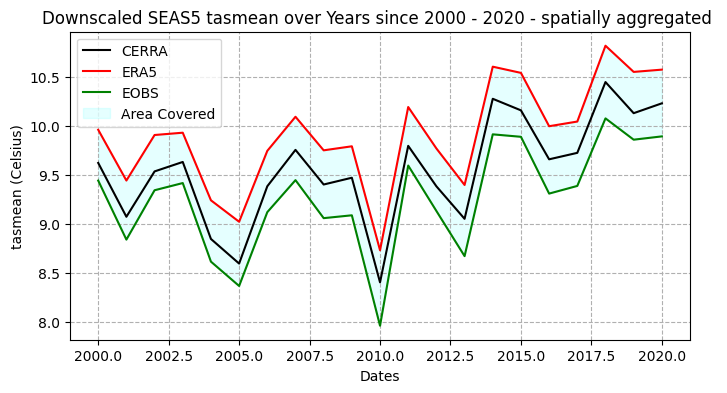

In [47]:
fig, ax = plt.subplots(1, 1, figsize = (8, 4))

colours = ['black','red','green','blue', 'cyan']
ax.plot(ref.year, ref.values, color=f'{colours[0]}', label=f'CERRA')
ax.plot(data.year, data.values, color=f'{colours[1]}', label=f'ERA5')
ax.plot(obs.year, obs.values, color=f'{colours[2]}', label=f'EOBS')
#ax.plot(data_10.month, data_10[:], color=f'{colours[3]}', label=f'Ensemble 10th Quantile')
ax.fill_between(ref.year, data[:], obs[:], alpha=0.1, color=f'{colours[4]}', label=f'Area Covered')

#ax.set_xlim(2020-01-01,2020-12-31)
ax.set_title(f'Downscaled SEAS5 {variable} over Years since 2000 - 2020 - spatially aggregated ')
ax.set_ylabel(f'{variable} (Celsius)')
ax.set_xlabel('Dates')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
ax.grid(linestyle='--')

fig.savefig(f'SEAS5_annual_{variable}.png')

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn

In [76]:
era5_df= era5.mean(dim=["y", "x"])
cerra_df = y_true.mean(dim=["y", "x"])
obs_df = y_pred.mean(dim=["y", "x"])

era5_df = era5_df.to_dataframe()
cerra_df = cerra_df.to_dataframe()
obs_df = obs_df.to_dataframe()


In [77]:
era5_df = era5_df.rename(columns={'tasmean': 'era5_tasmean'})
cerra_df = cerra_df.rename(columns={'tasmean': 'cerra_tasmean'})
obs_df = obs_df.rename(columns={'tasmean': 'obs_tasmean'})


In [80]:
merged_df = pd.merge(era5_df, cerra_df, on='time')
tasmean_df = pd.merge(merged_df, obs_df, on='time')
tasmean_df

,era5_tasmean,heightAboveGround,cerra_tasmean,obs_tasmean
time,,,,
2000-01-01,-1.187516,2.0,-1.085595,-1.055204
2000-01-02,0.012812,2.0,0.043042,-0.005950
2000-01-03,-0.667795,2.0,-0.675677,-0.200759
2000-01-04,0.362533,2.0,0.252351,1.048897
2000-01-05,1.815881,2.0,2.039486,2.247103
...,...,...,...,...
2020-12-27,-1.746104,2.0,-1.763922,-2.280426
2020-12-28,1.048348,2.0,0.807695,0.063657
2020-12-29,1.541991,2.0,1.443558,0.448944


In [75]:
era5_df

,tasmean
time,
2000-01-01,ERA5
2000-01-02,ERA5
2000-01-03,ERA5
2000-01-04,ERA5
2000-01-05,ERA5
...,...
2020-12-27,ERA5
2020-12-28,ERA5
2020-12-29,ERA5


In [81]:
tasmean_df = tasmean_df.drop(columns=["heightAboveGround"])


In [82]:
tasmean_df

,era5_tasmean,cerra_tasmean,obs_tasmean
time,,,
2000-01-01,-1.187516,-1.085595,-1.055204
2000-01-02,0.012812,0.043042,-0.005950
2000-01-03,-0.667795,-0.675677,-0.200759
2000-01-04,0.362533,0.252351,1.048897
2000-01-05,1.815881,2.039486,2.247103
...,...,...,...
2020-12-27,-1.746104,-1.763922,-2.280426
2020-12-28,1.048348,0.807695,0.063657
2020-12-29,1.541991,1.443558,0.448944


<Axes: xlabel='time', ylabel='tasmean'>

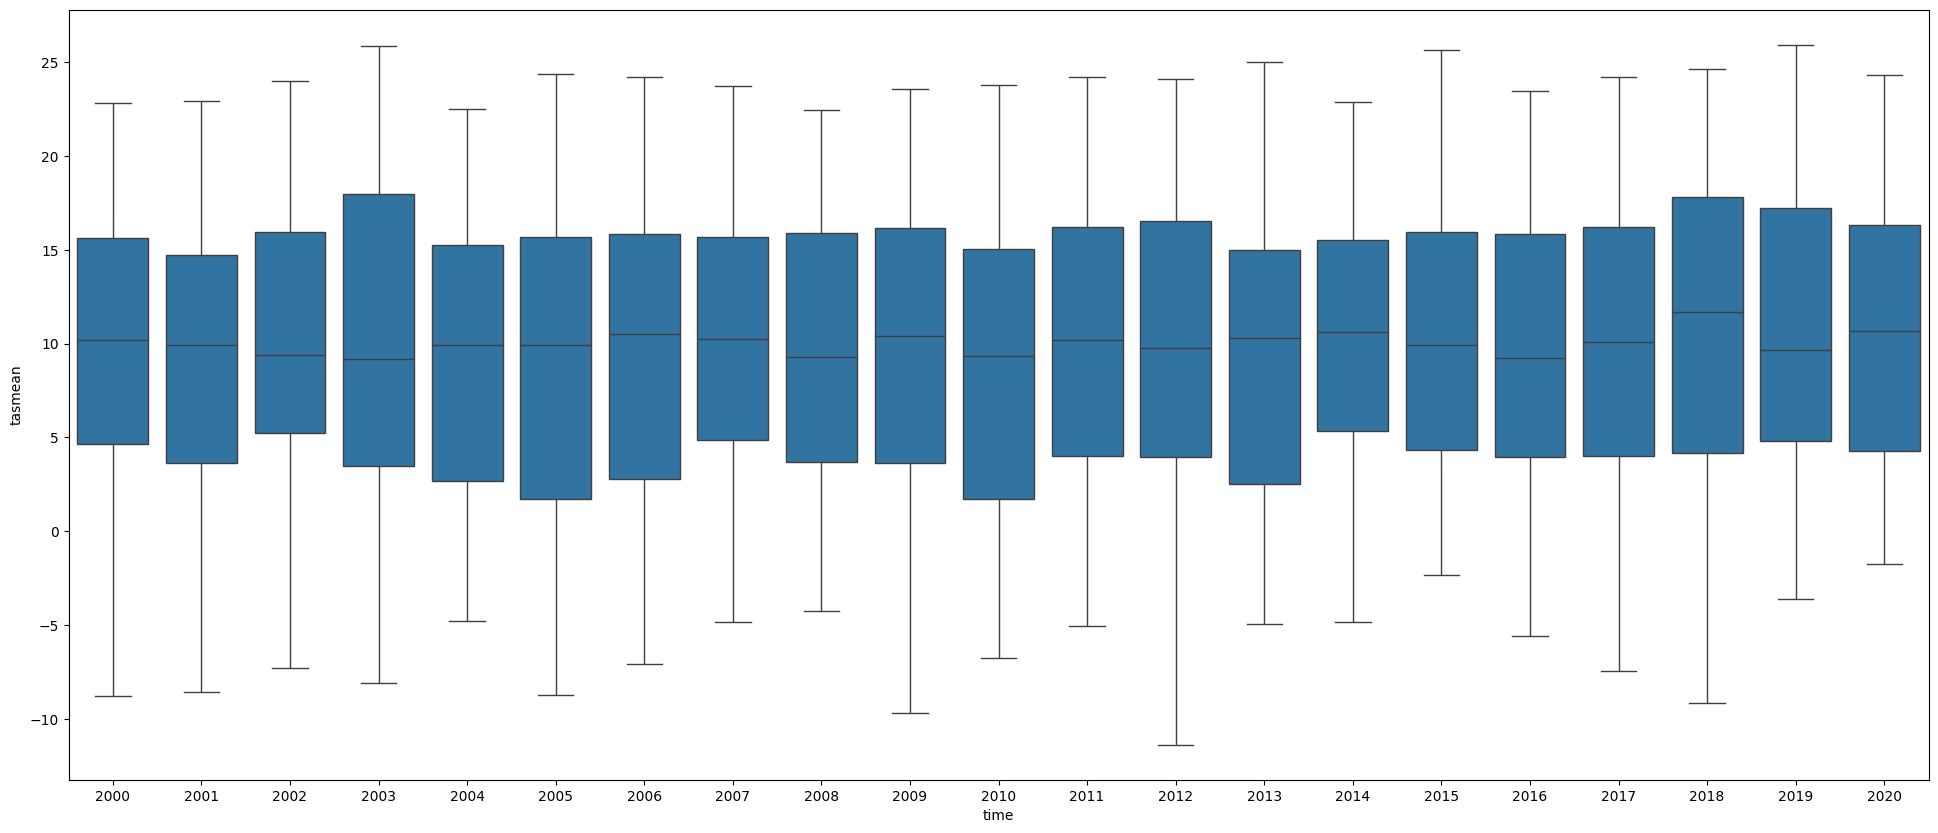

In [65]:
fig, ax = plt.subplots(figsize=(24,10))
seaborn.boxplot(x = era5_df.index.year,
                y = era5_df['tasmean'], 
                ax = ax)

In [83]:
tasmean_df

,era5_tasmean,cerra_tasmean,obs_tasmean
time,,,
2000-01-01,-1.187516,-1.085595,-1.055204
2000-01-02,0.012812,0.043042,-0.005950
2000-01-03,-0.667795,-0.675677,-0.200759
2000-01-04,0.362533,0.252351,1.048897
2000-01-05,1.815881,2.039486,2.247103
...,...,...,...
2020-12-27,-1.746104,-1.763922,-2.280426
2020-12-28,1.048348,0.807695,0.063657
2020-12-29,1.541991,1.443558,0.448944


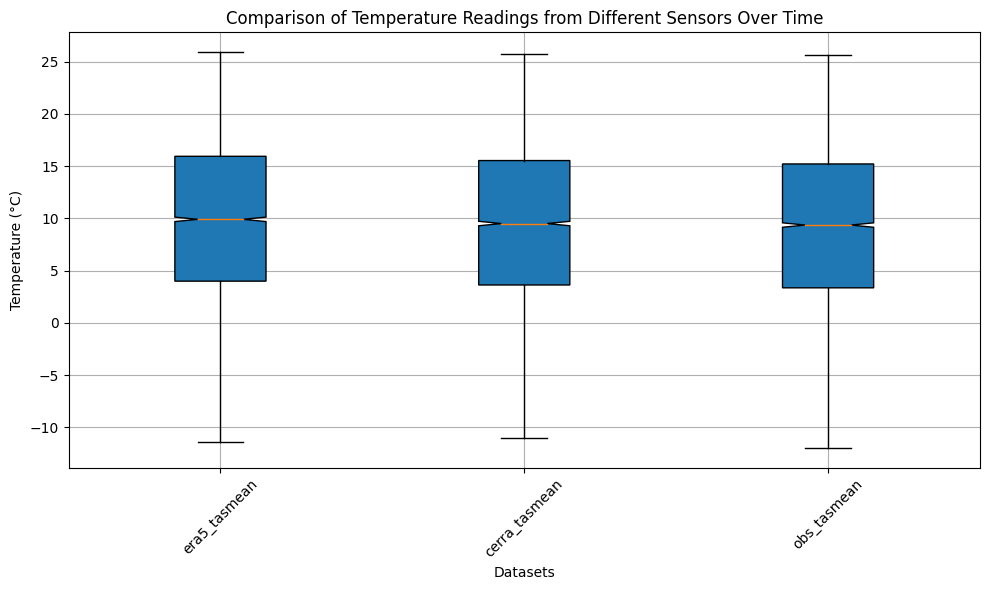

In [87]:

# Create a box plot of temperature data for each sensor
plt.figure(figsize=(10, 6))
plt.boxplot(
    [tasmean_df['era5_tasmean'], tasmean_df['cerra_tasmean'], tasmean_df['obs_tasmean']],
    labels=['era5_tasmean', 'cerra_tasmean', 'obs_tasmean'],
    notch=True,
    vert=True,
    patch_artist=True,
    showfliers=True
)

# Customize the plot
plt.xlabel('Datasets')
plt.ylabel('Temperature (°C)')
plt.title('Comparison of Temperature Readings from Different Sensors Over Time')
plt.grid(True)
plt.xticks(rotation=45)

# Display the box plot
plt.tight_layout()
plt.show()

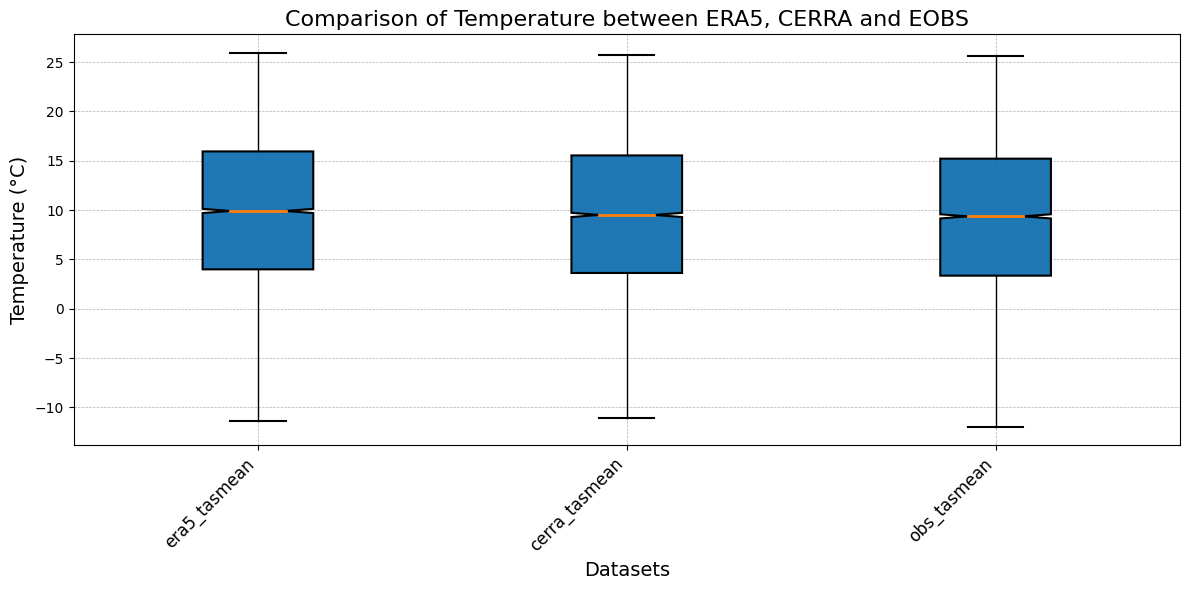

In [90]:
import matplotlib.pyplot as plt

# Assuming tasmean_df has your temperature data

plt.figure(figsize=(12, 6))  # Increased figure size for better visibility

# Adjust boxplot elements for better differentiation
plt.boxplot(
    [tasmean_df['era5_tasmean'], tasmean_df['cerra_tasmean'], tasmean_df['obs_tasmean']],
    labels=['era5_tasmean', 'cerra_tasmean', 'obs_tasmean'],
    notch=True,  # Maintains separation between boxes
    vert=True,
    patch_artist=True,
    medianprops={"linewidth": 2},  # Thicker median line
    boxprops={"linewidth": 1.5},  # Thicker box edges
    capprops={"linewidth": 1.5},  # Thicker whiskers
    flierprops={"marker": "o", "markersize": 5},  # Emphasize outliers
)

# Customize the plot
plt.xlabel('Datasets', fontsize=14)  # Larger font size for labels
plt.ylabel('Temperature (°C)', fontsize=14)
plt.title('Comparison of Temperature between ERA5, CERRA and EOBS', fontsize=16)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)  # Grid with finer lines

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right', fontsize=12)  # Rotate and adjust alignment

# Display the box plot with better layout
plt.tight_layout()
plt.show()
